In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [237]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [209]:
house_prices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [210]:
house_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

Model Preparation

1.Look for data types and missing values
2.Handle missing values, missing values are important since every datapoint is invaluable.
3.Draw histograms, if variables are tend to normally distributed use interpolation to fill missing values othervise fill them with median.
4.Look for outliers. Draw boxplots to see outliers and apply Tukey's test.
5.Deal with outliers with winsorizition if there is a need.
7.Draw scatter plot and correlation matrix to choose features.
8.Convert categorical variables
9.Apply same things for categorical variables.
10.Run Regression models
11.Interpret the results and features

## Do data cleaning, exploratory data analysis, and feature engineering.

In [211]:
# Let's look variable types, how many rows we have and how many columns.
print("Number of rows : {} and columns are:{}".format(house_prices_df.shape[0],house_prices_df.shape[1]))
print("Missing values")
print("--"*20)

def missing_check(x):
    y = house_prices_df[x]
    return round(y.isnull().sum()*100/y.isnull().count(),2)

missing_columns = list(house_prices_df.columns[house_prices_df.isnull().any()])

for col_names in missing_columns:
    print(col_names,missing_check(col_names))

Number of rows : 1460 and columns are:81
Missing values
----------------------------------------
lotfrontage 17.74
alley 93.77
masvnrtype 0.55
masvnrarea 0.55
bsmtqual 2.53
bsmtcond 2.53
bsmtexposure 2.6
bsmtfintype1 2.53
bsmtfintype2 2.6
electrical 0.07
fireplacequ 47.26
garagetype 5.55
garageyrblt 5.55
garagefinish 5.55
garagequal 5.55
garagecond 5.55
poolqc 99.52
fence 80.75
miscfeature 96.3


#### Miscfeature (96.3), pool.qc (99.52), fence(80.75), fireplacequ(47.26) and alley(93.77) have high percent of na values which is not reliable when we fill the na's. I will drop this variables before starting filling na process.

In [238]:
#dropping high percentage of missing values columns
house_prices_df.drop(['miscfeature','poolqc','fence','fireplacequ','alley','lotfrontage'], axis=1,inplace=True)

In [239]:
categorical = house_prices_df.select_dtypes(['object']).columns
numerical = house_prices_df.select_dtypes(['int64','float64']).columns

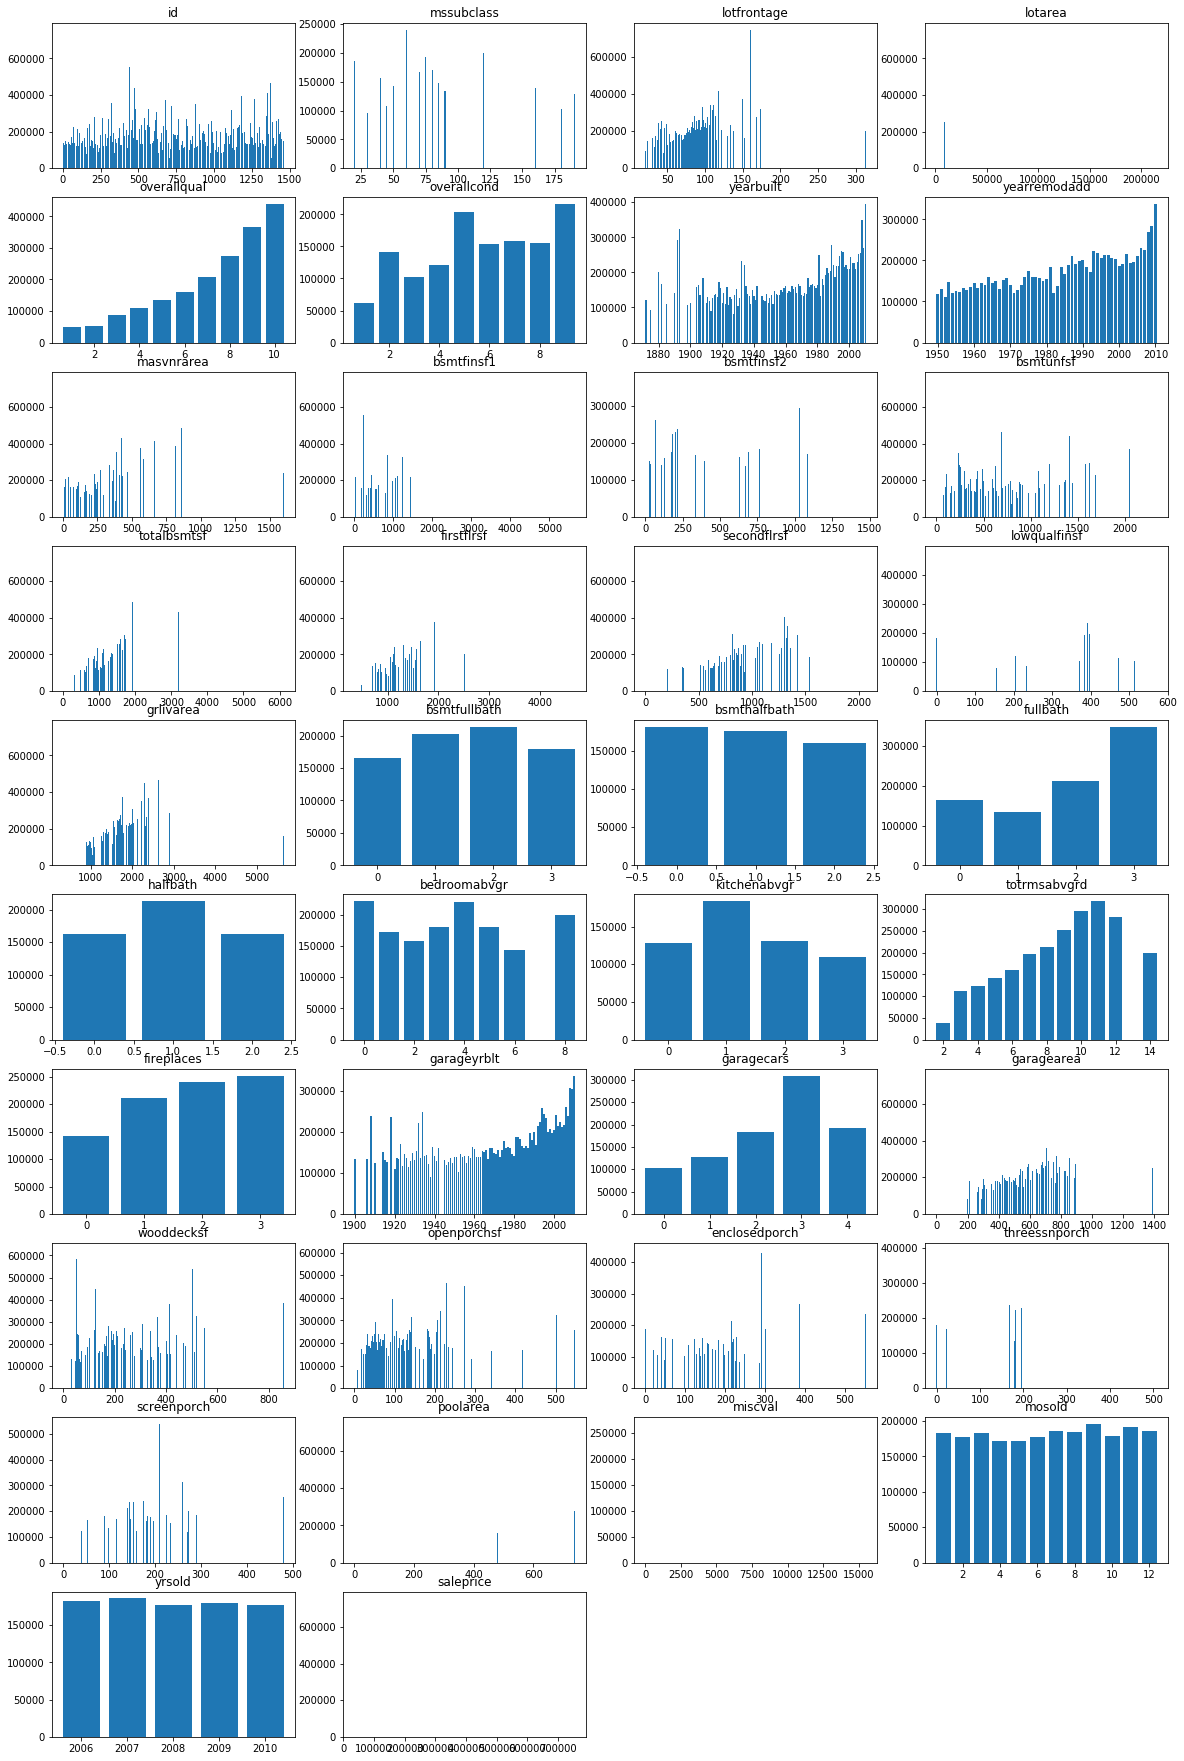

In [88]:
plt.figure(figsize = (20,70))

for col_number, col_names in enumerate(numerical):
  plt.subplot(22,4,(col_number+1))
  plt.bar(house_prices_df.groupby(col_names)["saleprice"].mean().index, 
          house_prices_df.groupby(col_names)["saleprice"].mean())
  plt.title(col_names)
plt.show()

Most of them are not normally distributed. It would be better to use median to fill na values.

In [216]:
#filling missing columns with interpolation method. 
for col in numerical:
    #house_prices_df.fillna(NaN)
    house_prices_df.loc[:, col].fillna(np.median,inplace=True) 

In [217]:
for col_names in numerical:
    print(col_names,missing_check(col_names))

id 0.0
mssubclass 0.0
lotarea 0.0
overallqual 0.0
overallcond 0.0
yearbuilt 0.0
yearremodadd 0.0
bsmtfinsf1 0.0
bsmtfinsf2 0.0
bsmtunfsf 0.0
totalbsmtsf 0.0
firstflrsf 0.0
secondflrsf 0.0
lowqualfinsf 0.0
grlivarea 0.0
bsmtfullbath 0.0
bsmthalfbath 0.0
fullbath 0.0
halfbath 0.0
bedroomabvgr 0.0
kitchenabvgr 0.0
totrmsabvgrd 0.0
fireplaces 0.0
garagecars 0.0
garagearea 0.0
wooddecksf 0.0
openporchsf 0.0
enclosedporch 0.0
threessnporch 0.0
screenporch 0.0
poolarea 0.0
miscval 0.0
mosold 0.0
yrsold 0.0
saleprice 0.0


#### Time to deal with outliers

In [241]:
# NumPy's percentile() method returns the 
# values of the given percentiles. In our case,
# we give 75 and 25 as parameters which corresponds 
# to the third and the first quartile.

for variable in list(numerical):
   q75, q25 = np.percentile(house_prices_df[variable], [75 ,25])
   iqr = q75 - q25

   min_val = q25 - (iqr*1.5)
   max_val = q75 + (iqr*1.5)
   print("Number of outliers and percentage of it in {} : {} and {}".format(variable,
                                                                             len((np.where((house_prices_df[variable] > max_val) | 
                                                                                           (house_prices_df[variable] < min_val))[0])),len((np.where((house_prices_df[variable] > max_val) | 
                                                                                           (house_prices_df[variable] < min_val))[0]))*100/1460))   


Number of outliers and percentage of it in id : 0 and 0.0
Number of outliers and percentage of it in mssubclass : 103 and 7.054794520547945
Number of outliers and percentage of it in lotarea : 69 and 4.726027397260274
Number of outliers and percentage of it in overallqual : 2 and 0.136986301369863
Number of outliers and percentage of it in overallcond : 125 and 8.561643835616438
Number of outliers and percentage of it in yearbuilt : 7 and 0.4794520547945205
Number of outliers and percentage of it in yearremodadd : 0 and 0.0
Number of outliers and percentage of it in masvnrarea : 0 and 0.0
Number of outliers and percentage of it in bsmtfinsf1 : 7 and 0.4794520547945205
Number of outliers and percentage of it in bsmtfinsf2 : 167 and 11.438356164383562
Number of outliers and percentage of it in bsmtunfsf : 29 and 1.9863013698630136
Number of outliers and percentage of it in totalbsmtsf : 61 and 4.178082191780822
Number of outliers and percentage of it in firstflrsf : 20 and 1.369863013698

Text(0.5, 1.0, 'Box Plot of creenporch After Winsorize')

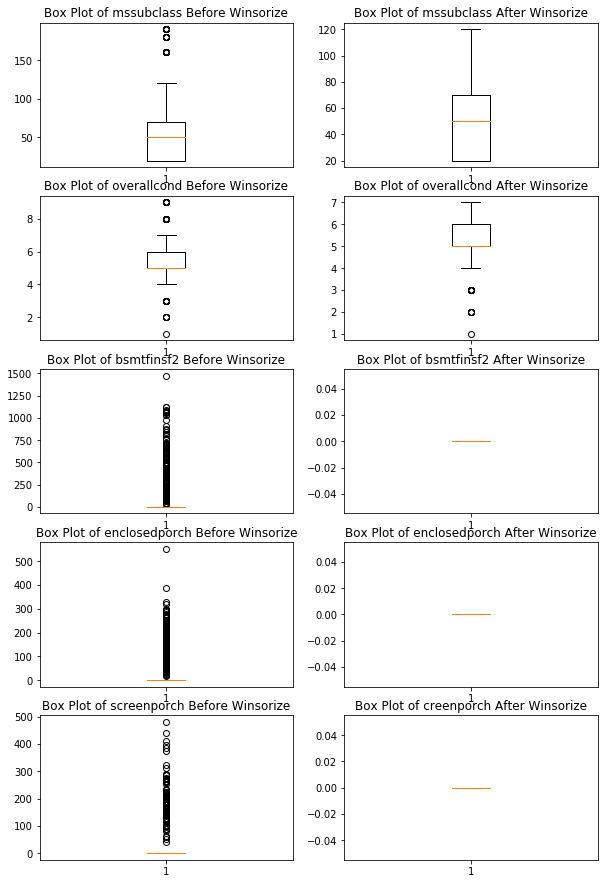

In [242]:
from scipy.stats.mstats import winsorize

plt.figure(figsize=(10,60))


house_prices_df['winsorized_mssubclass'] = winsorize(house_prices_df["mssubclass"], (0, 0.071))

plt.subplot(19,2,1)
plt.boxplot(house_prices_df['mssubclass'])
plt.title("Box Plot of mssubclass Before Winsorize")

plt.subplot(19,2,2)
plt.boxplot(house_prices_df['winsorized_mssubclass'])
plt.title("Box Plot of mssubclass After Winsorize")

###

house_prices_df['winsorized_overallcond'] = winsorize(house_prices_df["overallcond"], (0, 0.085))

plt.subplot(19,2,3)
plt.boxplot(house_prices_df['overallcond'])
plt.title("Box Plot of overallcond Before Winsorize")

plt.subplot(19,2,4)
plt.boxplot(house_prices_df['winsorized_overallcond'])
plt.title("Box Plot of overallcond After Winsorize")

####bsmtfinsf2 : 167 and 11.438356164383562

house_prices_df['winsorized_bsmtfinsf2'] = winsorize(house_prices_df["bsmtfinsf2"], (0, 0.12))

plt.subplot(19,2,5)
plt.boxplot(house_prices_df['bsmtfinsf2'])
plt.title("Box Plot of bsmtfinsf2 Before Winsorize")

plt.subplot(19,2,6)
plt.boxplot(house_prices_df['winsorized_bsmtfinsf2'])
plt.title("Box Plot of bsmtfinsf2 After Winsorize")
                                                     
                                                     
###enclosedporch : 208 and 14.246575342465754

house_prices_df['winsorized_enclosedporch'] = winsorize(house_prices_df["enclosedporch"], (0, 0.15))

plt.subplot(19,2,7)
plt.boxplot(house_prices_df['enclosedporch'])
plt.title("Box Plot of enclosedporch Before Winsorize")

plt.subplot(19,2,8)
plt.boxplot(house_prices_df['winsorized_enclosedporch'])
plt.title("Box Plot of enclosedporch After Winsorize")
                                                     
###creenporch : 116 and 7.945205479452055
                                                     
house_prices_df['winsorized_screenporch'] = winsorize(house_prices_df["screenporch"], (0, 0.08))


plt.subplot(19,2,9)
plt.boxplot(house_prices_df['screenporch'])
plt.title("Box Plot of screenporch Before Winsorize")

plt.subplot(19,2,10)
plt.boxplot(house_prices_df['winsorized_screenporch'])
plt.title("Box Plot of creenporch After Winsorize")                                                     
                                                     
                                                     

In [243]:
xx = ['winsorized_overallcond','winsorized_mssubclass','winsorized_bsmtfinsf2','winsorized_enclosedporch','winsorized_screenporch']
numerical1 = list(numerical)
numerical = numerical1+xx

In [244]:
corr_list = np.abs(house_prices_df[numerical].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)
corr_list

saleprice                   1.000000
overallqual                 0.790982
grlivarea                   0.708624
garagecars                  0.640409
garagearea                  0.623431
totalbsmtsf                 0.613581
firstflrsf                  0.605852
fullbath                    0.560664
totrmsabvgrd                0.533723
yearbuilt                   0.522897
yearremodadd                0.507101
garageyrblt                 0.486362
masvnrarea                  0.477493
fireplaces                  0.466929
bsmtfinsf1                  0.386420
wooddecksf                  0.324413
secondflrsf                 0.319334
openporchsf                 0.315856
halfbath                    0.284108
lotarea                     0.263843
bsmtfullbath                0.227122
bsmtunfsf                   0.214479
bedroomabvgr                0.168213
kitchenabvgr                0.135907
enclosedporch               0.128578
screenporch                 0.111447
poolarea                    0.092404
w

In [245]:
Possible_features = ['overallqual',
'grlivarea',
'garagecars',
'garagearea',
'totalbsmtsf',
'firstflrsf',
'fullbath',
'totrmsabvgrd',
'yearbuilt',
'yearremodadd',
'fireplaces',
'bsmtfinsf1',
'wooddecksf',
'secondflrsf',
'openporchsf']

Scatter plots help us to identify relation better. I'll draw 15 plots.

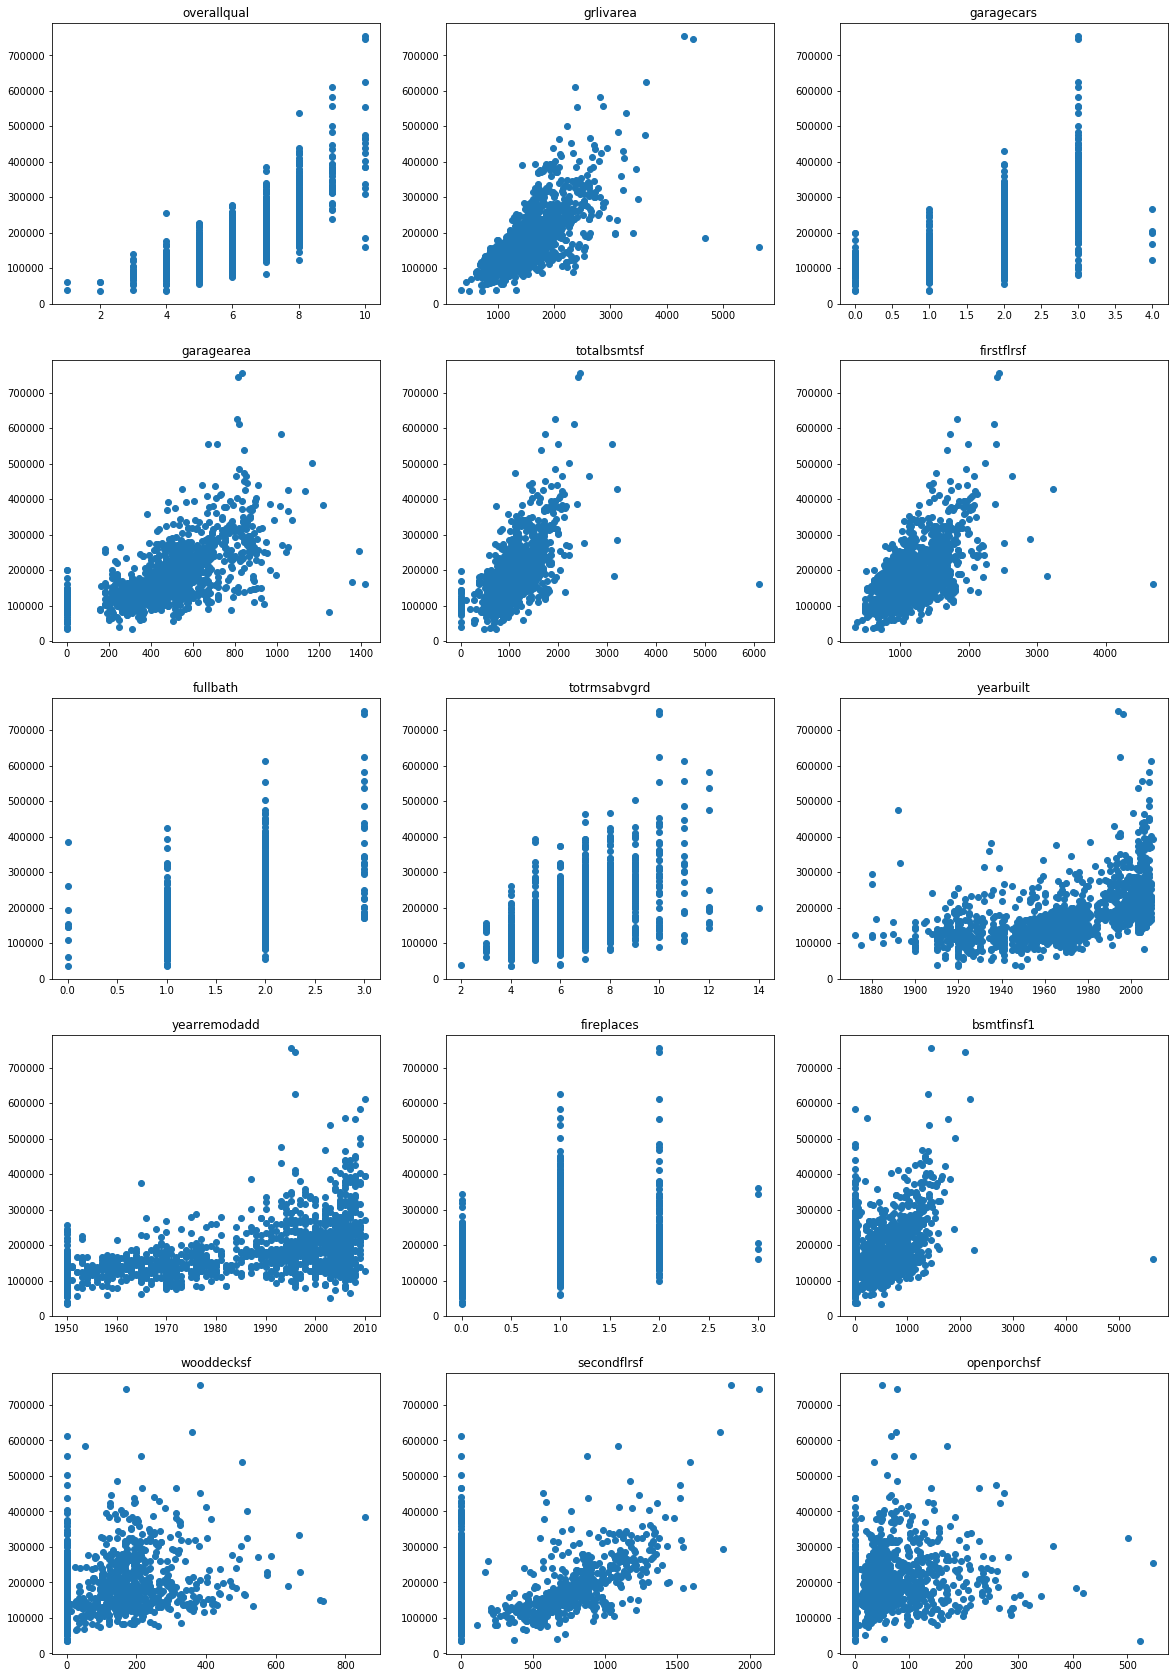

In [246]:
plt.figure(figsize=(20,30))
for i in range(len(Possible_features)):
    plt.subplot(5,3,i+1)
    plt.scatter(house_prices_df[Possible_features[i]],Y)
    plt.title(Possible_features[i])
plt.show()

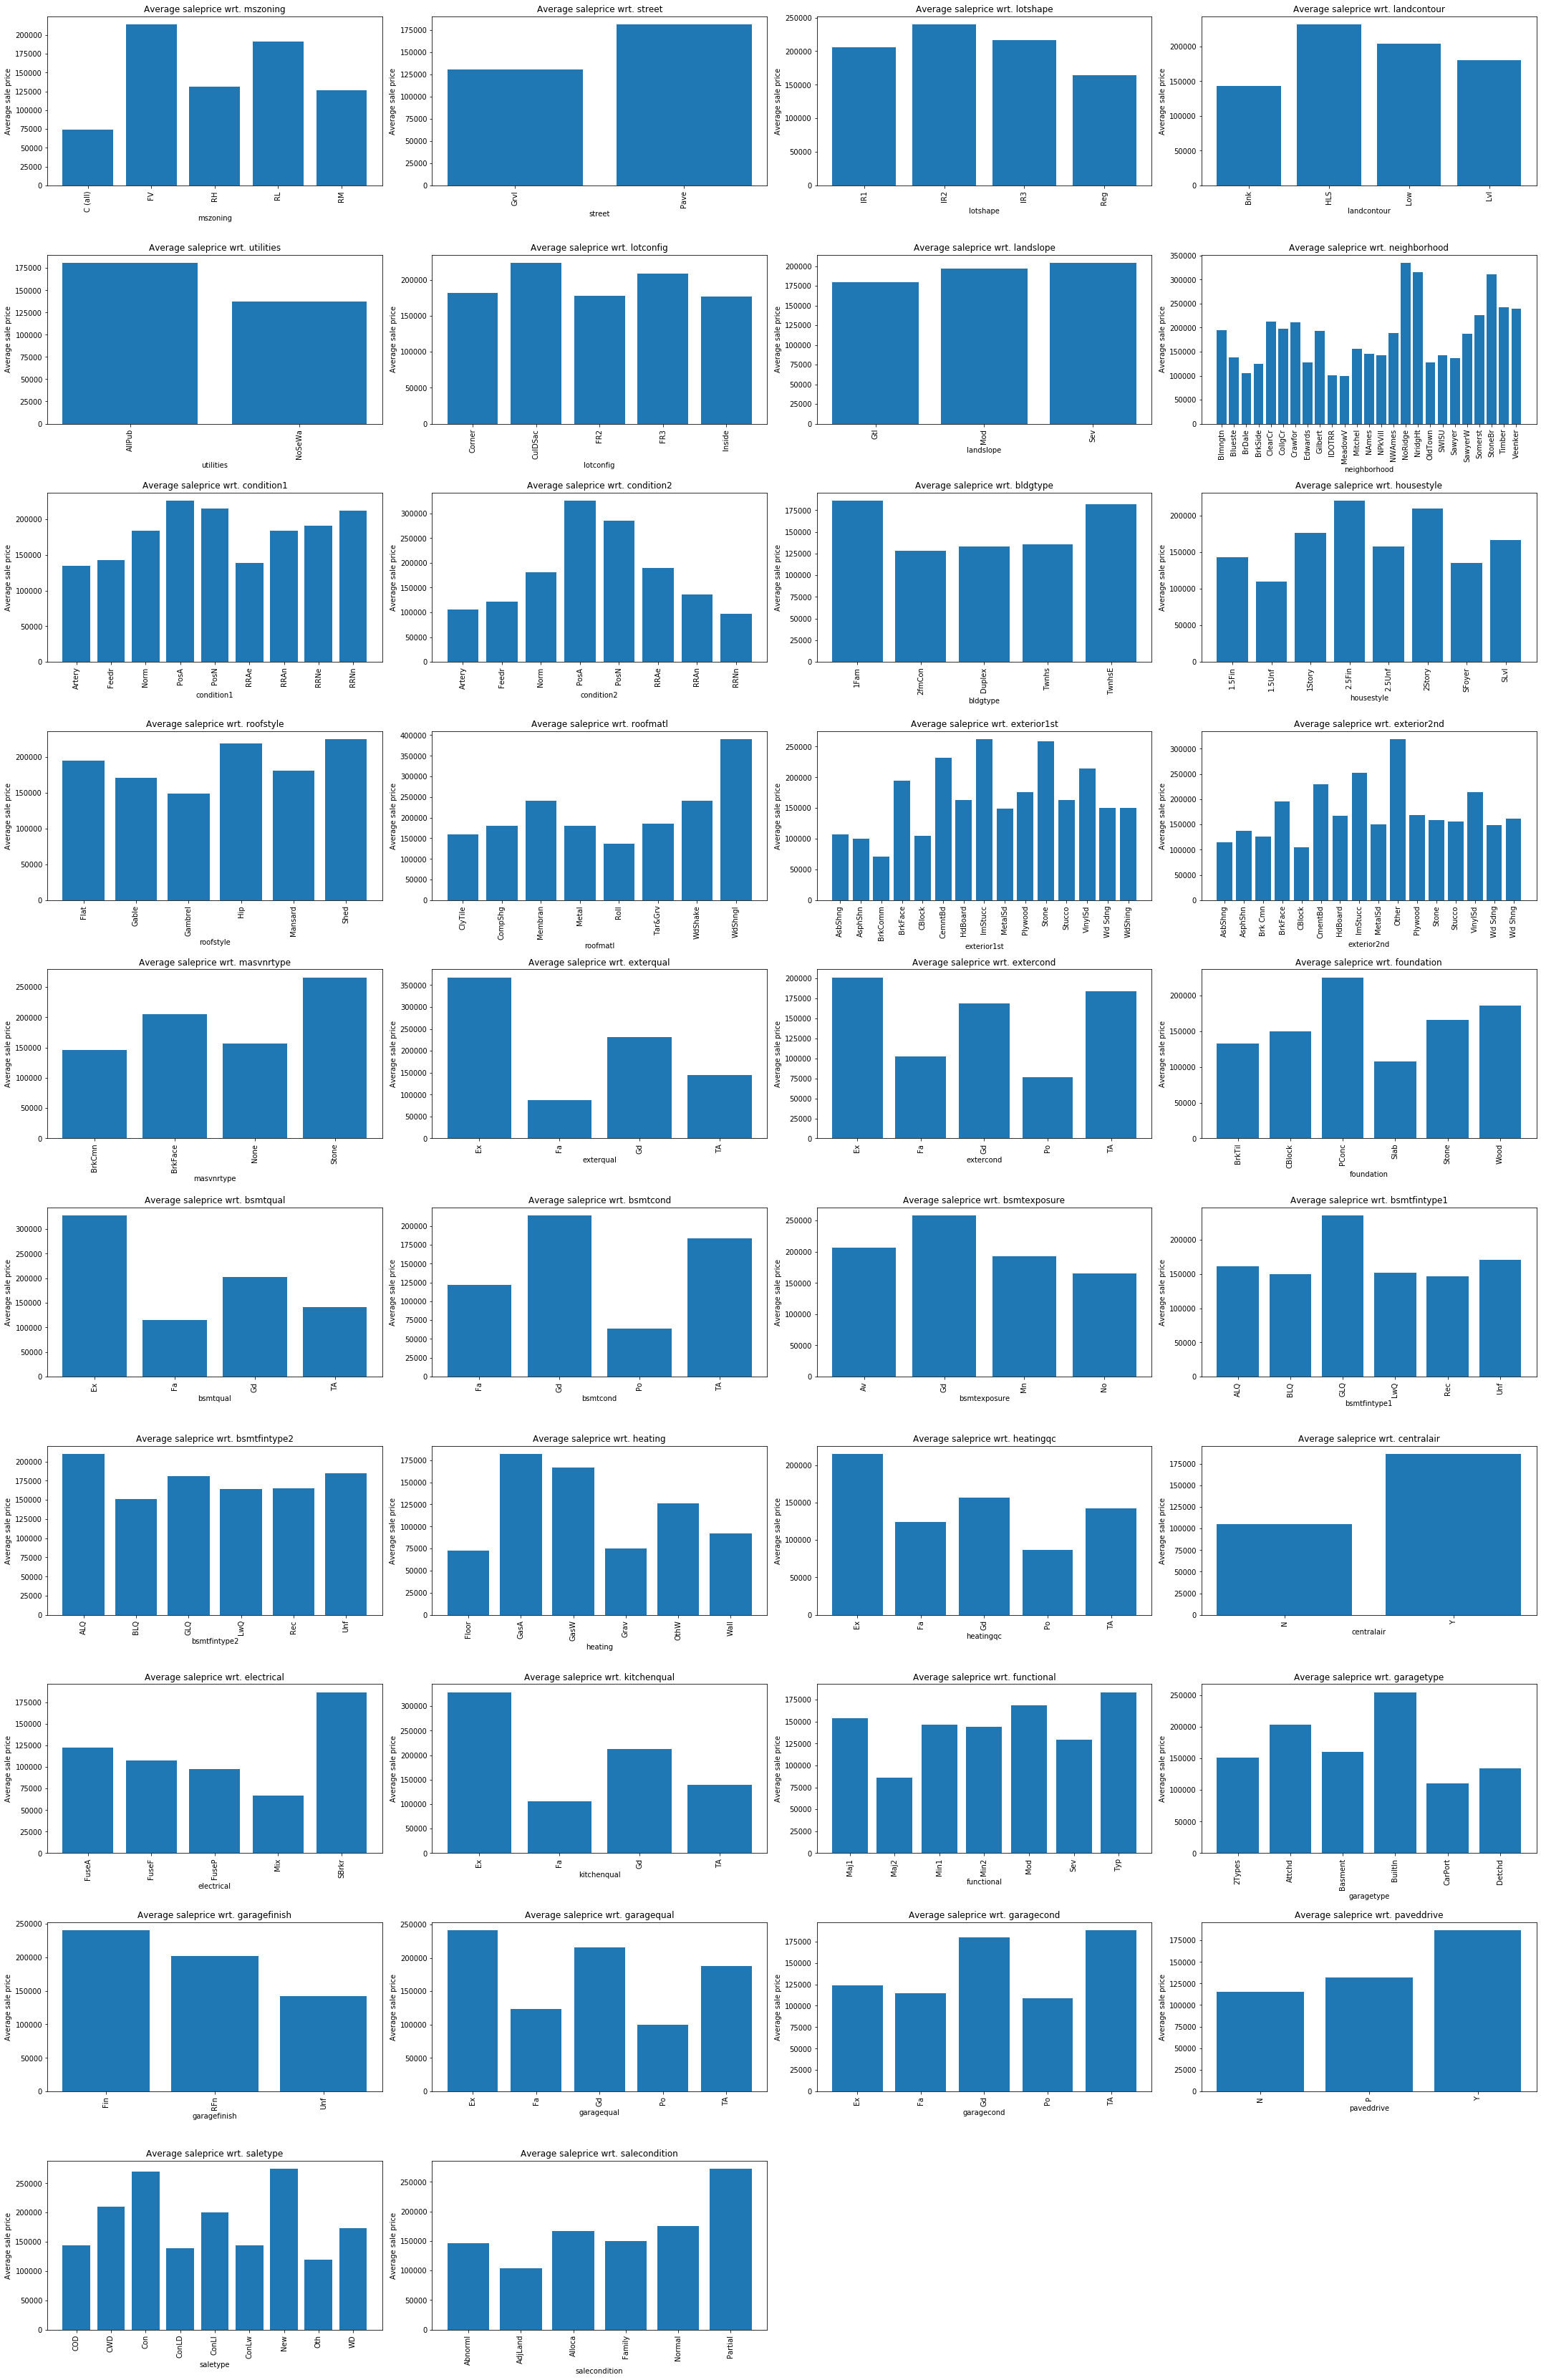

In [247]:
plt.figure(figsize=(30,50))

for index, column in enumerate(categorical):
    plt.subplot(11,4,index+1)
    plt.bar(house_prices_df.groupby(column)['saleprice'].mean().index, house_prices_df.groupby(column)['saleprice'].mean())
    plt.title('Average saleprice wrt. {}'.format(column))
    plt.ylabel('Average sale price')
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

As our scatter plots help us to understand the relationship between sale price and numerical variables I choose 15 most correlated variables from data frame. Also, I added two non-numerical features mszoning and street to our model as their values exhibit some variance with respect to the average sale price. In order to use them in our model, we need to convert them to dummy variables.

In [248]:
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

In [250]:
X = house_prices_df[Possible_features + dummy_column_names]
Y = house_prices_df.saleprice

Text(0.5, 1, 'correlation matrix (X)')

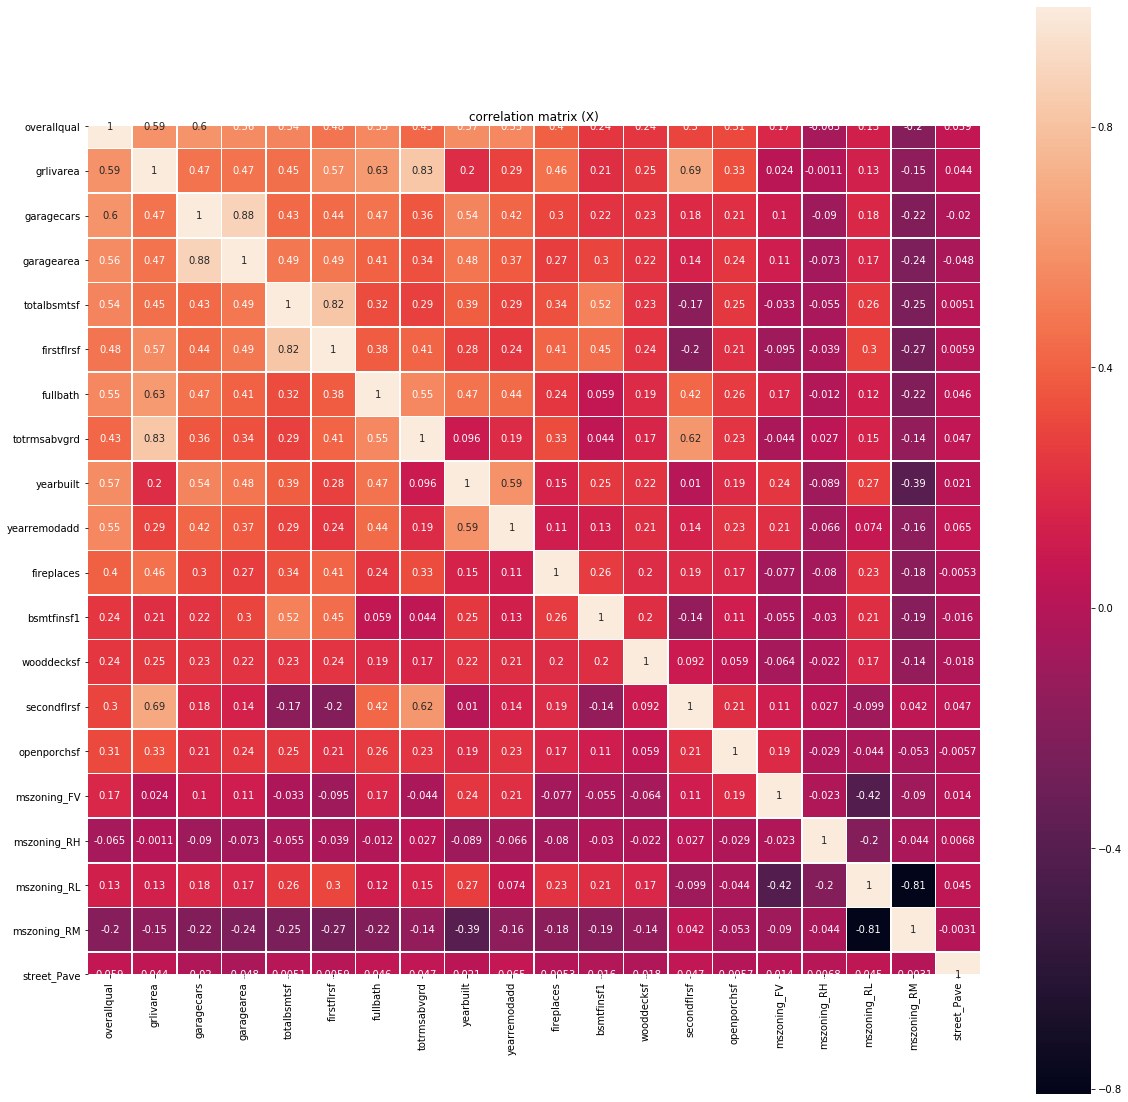

In [251]:
plt.figure(figsize=(20,20))
sns.heatmap(X.corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (X)")

There are many correlated columns, I will drop these variables.

In [253]:
drop_list = ['overallqual', 'firstflrsf', 'fullbath', 'totrmsabvgrd','garagearea', 'bsmtfinsf1', 'secondflrsf','yearbuilt','mszoning_RM']
X.drop(drop_list, axis =1, inplace=True)




Text(0.5, 1, 'correlation matrix (X)')

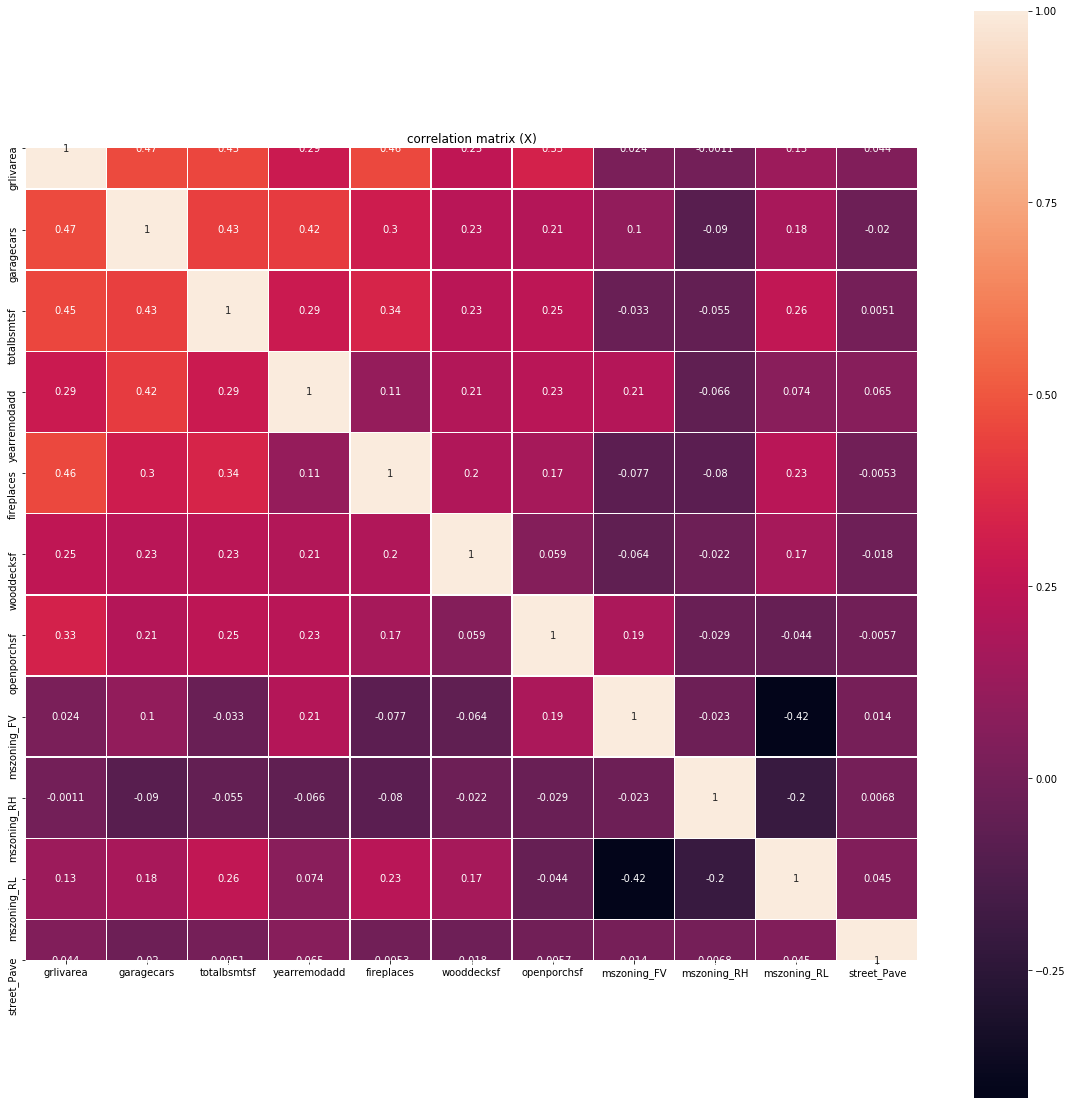

In [255]:
#check again
plt.figure(figsize=(20,20))
sns.heatmap(X.corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (X)")

In [256]:
X.corrwith(Y)
X.drop(['mszoning_RH', 'mszoning_FV','street_Pave'],axis=1, inplace=True)

# Regression Model

In [ ]:
#Now, split your data into train and test sets where 20% of the data resides in the test set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 465 )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [261]:
import statsmodels.api as sm
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     683.5
Date:                Sun, 09 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:01:30   Log-Likelihood:                 408.92
No. Observations:                1460   AIC:                            -799.8
Df Residuals:                    1451   BIC:                            -752.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.7171      0.517      1.387      0.166      -0.297       1.731
grlivarea        0.0002   1.19e-05     20.428      0.000       0.000       0.000
garagecars       0.1399      0.008     17.473      0.000       0.124       0.156
totalbsmtsf      0.0002   1.33e-05     12.450      0.000       0.000       0.000
yearremodadd     0.0052      0.000     19.782      0.000       0.005       0.006
fireplaces       0.0808      0.009      9.310      0.000       0.064       0.098
wooddecksf       0.0002   4.07e-05      4.073      0.000    8.59e-05       0.000
openporchsf      0.0002   7.87e-05      2.522      0.012    4.41e-05       0.000
mszoning_RL      0.1042      0.013      8.334      0.000       0.080       0.129
==============================================================================
Omnibus:                      892.123   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29327.075
Skew:                          -2.293   Prob(JB):                         0.00
Kurtosis:                      24.472   Cond. No.                     2.96e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.96e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

the closer the value of MSE is to "0", the better. 


* Except the variable "openporchsf", all other variables are significantly important. They have small p-value.
- When we check F-test, p-value related with F-test is 0 which means our model is useful and contributes something that is statistically significant in the explanation of the target.
- Adjusted R-squared is 0.790 which is good. Since it is a little bit high, I am suspicios if there is an overfit.
- In this point, I can examine adding interaction variables to the model and look for the accuracy change. However, R-square is high and I have 7 variables. Instead of this I will try different regression models.

In [262]:
X.drop(['openporchsf'], axis=1, inplace=True)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 465 )
X = sm.add_constant(X)
Y =
results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     777.4
Date:                Sun, 09 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:03:27   Log-Likelihood:                 405.72
No. Observations:                1460   AIC:                            -795.4
Df Residuals:                    1452   BIC:                            -753.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.5521      0.514      1.074      0.283      -0.456       1.560
grlivarea        0.0002   1.17e-05     21.337      0.000       0.000       0.000
garagecars       0.1401      0.008     17.471      0.000       0.124       0.156
totalbsmtsf      0.0002   1.33e-05     12.783      0.000       0.000       0.000
yearremodadd     0.0053      0.000     20.214      0.000       0.005       0.006
fireplaces       0.0815      0.009      9.376      0.000       0.064       0.099
wooddecksf       0.0002   4.07e-05      3.951      0.000     8.1e-05       0.000
mszoning_RL      0.1003      0.012      8.071      0.000       0.076       0.125
==============================================================================
Omnibus:                      874.931   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27548.371
Skew:                          -2.241   Prob(JB):                         0.00
Kurtosis:                      23.803   Cond. No.                     2.93e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- R-squared and adjusted R-squared are almost same. But, F-statistic is higher in second model. We can say that second model is better than the first one. I will continue with second model's variables.

# Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

In [264]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

R_sqr = lrm.score(X_train, y_train)
R_sqr_test = lrm.score(X_test, y_test)
mae_test = mean_absolute_error(y_test, y_preds_test)
mse_test = mse(y_test, y_preds_test)
rmse_test = rmse(y_test, y_preds_test)

print("R-squared of the model in training set is: {}".format(R_sqr))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(R_sqr_test))
print("Mean absolute error of the prediction is: {}".format(mae))
print("Mean squared error of the prediction is: {}".format(mse))
print("Root mean squared error of the prediction is: {}".format(rmse))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

results_data= []
results_data.append(['OLS', R_sqr, R_sqr_test, mae_test, mse_test, rmse_test])


R-squared of the model in training set is: 0.7800582002461719
-----Test set statistics-----
R-squared of the model in test set is: 0.8208913478305769
Mean absolute error of the prediction is: 25006.742064151687
Mean squared error of the prediction is: <function mse at 0x1a178d7cb0>
Root mean squared error of the prediction is: <function rmse at 0x1a17d09050>
Mean absolute percentage error of the prediction is: 1.052726719109458


### R-square difference between test and train set is 0.05. It will be sign of overfitting.



To make a model more generalizable a test set, we sometimes adjust the model's learning objectives or loss functions. By doing this, we actually impose our preferences over potential solutions and force the model to choose one of our preferred solutions, assuming there isn't a nonpreferred solution that performs significantly better. In general, the term regularization refers to the process of modifying algorithms in order to lower the generalization gap without sacrificing training performance.We can get more accurate predictions by modifying this cost function. 


### Ridge Regression

In [265]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [266]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

R_sqr = ridge_cv.score(X_train, y_train)
R_sqr_test = ridge_cv.score(X_test, y_test)
mae_test = mean_absolute_error(y_test, y_preds_test)
mse_test = mse(y_test, y_preds_test)
rmse_test = rmse(y_test, y_preds_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(R_sqr))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(R_sqr_test))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

results_data.append(['Ridge', R_sqr, R_sqr_test, mae_test, mse_test, rmse_test])


Best alpha value is: 1.0
R-squared of the model in training set is: 0.7800575921287156
-----Test set statistics-----
R-squared of the model in test set is: 0.820966545615958
Mean absolute error of the prediction is: 0.12607211874210664
Mean squared error of the prediction is: 0.029853049511197494
Root mean squared error of the prediction is: 0.17278035047770188
Mean absolute percentage error of the prediction is: 1.0526173947277682


### Lasso Regression

In [267]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

R_sqr = lasso_cv.score(X_train, y_train)
R_sqr_test = lasso_cv.score(X_test, y_test)
mae_test = mean_absolute_error(y_test, y_preds_test)
mse_test = mse(y_test, y_preds_test)
rmse_test = rmse(y_test, y_preds_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))

print("R-squared of the model in training set is: {}".format(R_sqr))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(R_sqr_test))
print("Mean absolute error of the prediction is: {}".format(mae_test))
print("Mean squared error of the prediction is: {}".format(mse_test))
print("Root mean squared error of the prediction is: {}".format(rmse_test))

print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


results_data.append(['Lasso', R_sqr, R_sqr_test, mae_test, mse_test, rmse_test])

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.7800582002461718
-----Test set statistics-----
R-squared of the model in test set is: 0.8208913478971039
Mean absolute error of the prediction is: 0.12608609658354308
Mean squared error of the prediction is: 0.029865588403617374
Root mean squared error of the prediction is: 0.17281663231187377
Mean absolute percentage error of the prediction is: 1.052726719001341


### ElasticNet Regression

In [268]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

R_sqr = elasticnet_cv.score(X_train, y_train)
R_sqr_test = elasticnet_cv.score(X_test, y_test)
mae_test = mean_absolute_error(y_test, y_preds_test)
mse_test = mse(y_test, y_preds_test)
rmse_test = rmse(y_test, y_preds_test)


print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(R_sqr))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(R_sqr_test))
print("Mean absolute error of the prediction is: {}".format(mae_test))
print("Mean squared error of the prediction is: {}".format(mse_test))
print("Root mean squared error of the prediction is: {}".format(rmse_test))

print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


results_data.append(['ElasticNet', R_sqr, R_sqr_test, mae_test, mse_test, rmse_test])

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.7800582002461719
-----Test set statistics-----
R-squared of the model in test set is: 0.8208913478682814
Mean absolute error of the prediction is: 0.12608609658963418
Mean squared error of the prediction is: 0.029865588408423398
Root mean squared error of the prediction is: 0.17281663232577876
Mean absolute percentage error of the prediction is: 1.052726719049


In [269]:
models_summary = pd.DataFrame(results_data, columns = ['Model_Name', 'R_sqr', 'R_sqr_test', 'MAE', 'MSE','RMSE']) 
models_summary['R_square_difference'] = models_summary['R_sqr']-models_summary['R_sqr_test']

In [270]:
models_summary

,Model_Name,R_sqr,R_sqr_test,MAE,MSE,RMSE,R_square_difference
0,OLS,0.780058,0.820891,0.126086,0.029866,0.172817,-0.040833
1,Ridge,0.780058,0.820967,0.126072,0.029853,0.172780,-0.040909
2,Lasso,0.780058,0.820891,0.126086,0.029866,0.172817,-0.040833
3,ElasticNet,0.780058,0.820891,0.126086,0.029866,0.172817,-0.040833


Almost all model results are same. There could be slightly differences but with these results we couldn't choose a winner.

## So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

This dataset contains world's share prices from 1950 to present.
The data can be reached from "https://data.oecd.org/price/share-prices.htm#indicator-chart"

In [272]:
share_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CPI.TOT.AGRWTH.A/OECD?contentType=csv&detail=code&separator=comma&csv-lang=en&startPeriod=1950&endPeriod=2017")

In [273]:
share_df.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,CPI,TOT,AGRWTH,A,1950,8.695652,NaN
1,AUS,CPI,TOT,AGRWTH,A,1951,19.428570,NaN
2,AUS,CPI,TOT,AGRWTH,A,1952,17.224880,NaN
3,AUS,CPI,TOT,AGRWTH,A,1953,4.489796,NaN
4,AUS,CPI,TOT,AGRWTH,A,1954,1.562500,NaN


In [280]:
share_df = share_df[share_df['LOCATION']=='USA'][['TIME','Value']]

Both data have year column common. I will join two dataframes based on this column.

In [281]:
X_new = X.merge(share_df, left_on='yearremodadd',right_on = 'TIME' ,how='left')
X_new.drop(['TIME'], axis=1, inplace=True)
X_new.fillna(X_new['Value'].mean(), inplace=True)

In [283]:

Y = house_prices_df.saleprice
X_train, X_test, y_train, y_test = train_test_split(X_new,Y, test_size = 0.2, random_state = 465 )

import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

R_sqr = lrm.score(X_train, y_train)
R_sqr_test = lrm.score(X_test, y_test)
mae_test = mean_absolute_error(y_test, y_preds_test)
mse_test = mse(y_test, y_preds_test)
rmse_test = rmse(y_test, y_preds_test)

print("R-squared of the model in training set is: {}".format(R_sqr))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(R_sqr_test))
print("Mean absolute error of the prediction is: {}".format(mae))
print("Mean squared error of the prediction is: {}".format(mse))
print("Root mean squared error of the prediction is: {}".format(rmse))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

results_data.append(['OLS_new_feature', R_sqr, R_sqr_test, mae_test, mse_test, rmse_test])

R-squared of the model in training set is: 0.7315884981259351
-----Test set statistics-----
R-squared of the model in test set is: 0.7536693772716994
Mean absolute error of the prediction is: 25006.742064151687
Mean squared error of the prediction is: <function mse at 0x1a178d7cb0>
Root mean squared error of the prediction is: <function rmse at 0x1a17d09050>
Mean absolute percentage error of the prediction is: 14.556062772888612


In [285]:
models_summary = pd.DataFrame(results_data, columns = ['Model_Name', 'R_sqr', 'R_sqr_test', 'MAE', 'MSE','RMSE'])
models_summary

,Model_Name,R_sqr,R_sqr_test,MAE,MSE,RMSE
0,OLS,0.780058,0.820891,0.126086,2.986559e-02,0.172817
1,Ridge,0.780058,0.820967,0.126072,2.985305e-02,0.172780
2,Lasso,0.780058,0.820891,0.126086,2.986559e-02,0.172817
3,ElasticNet,0.780058,0.820891,0.126086,2.986559e-02,0.172817
4,OLS_new_feature,0.731588,0.753669,25485.267521,1.653791e+09,40666.828086


Adding a new feature didn't increase our model's performance.